<a href="https://colab.research.google.com/github/correalipe/Betting-Data-Analysis/blob/main/Registration_Funnel_and_Customer_Quality_Before_and_After_Validation_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === 1. Montar Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# === 2. Importar bibliotecas ===
!pip install xlsxwriter
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 4.5 MB/s eta 0:00:00


In [12]:
# Definir o caminho base
base_path = '/content/drive/MyDrive/Task 2 - Kaizen Gaming/'

# Carregar os arquivos
customers = pd.read_csv(base_path + 'Customer.txt', sep=',')
acquisition = pd.read_csv(base_path + 'Acquisition Channel.txt', sep=',')
deposits = pd.read_csv(base_path + 'Deposits.csv', sep=',')
ga = pd.read_csv(base_path + 'Google_Analytics_data_202209.csv', sep=',')
date = pd.read_csv(base_path + 'Date.csv', sep=',')

# Visualizar formas das tabelas para checagem
print("Customers:", customers.shape)
print("Acquisition:", acquisition.shape)
print("Deposits:", deposits.shape)
print("Google Analytics:", ga.shape)
print("Date:", date.shape)

# Mostrar as primeiras linhas de cada tabela para inspeção
customers.head()

/tmp/ipython-input-12-243437761.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  deposits = pd.read_csv(base_path + 'Deposits.csv', sep=',')


Customers: (1854937, 4)
Acquisition: (1179063, 2)
Deposits: (5891956, 6)
Google Analytics: (3935063, 6)
Date: (92, 22)


,Customer_ID,Customer_DateCreation_ID,Customer_Platform_Name,Customer_Product_Name
0,64755556,20220907,Mobile,Sportsbook
1,64756095,20220907,Mobile,Sportsbook
2,64756977,20220907,Mobile,Sportsbook
3,64757040,20220907,Mobile,Sportsbook
4,64759623,20220907,Mobile,Casino


In [13]:
# Converter e filtrar datas
customers['Customer_DateCreation_ID'] = pd.to_datetime(customers['Customer_DateCreation_ID'], format='%Y%m%d', errors='coerce')
customers = customers.dropna(subset=['Customer_DateCreation_ID'])
cutoff_date = pd.to_datetime('2022-09-16')
customers['Group'] = customers['Customer_DateCreation_ID'].apply(lambda x: 'before' if x < cutoff_date else 'after')

# IDs válidos na GA
ga_valid = ga[ga['customerId'].notna()].copy()
ga_valid['customerId'] = ga_valid['customerId'].astype(int)
ga_customers = ga_valid[['customerId']].drop_duplicates().rename(columns={'customerId': 'Customer_ID'})

# Merge com grupo
customers_subset = customers[['Customer_ID', 'Group']].drop_duplicates()
email_customers = ga_customers.merge(customers_subset, on='Customer_ID', how='left')
print("Clientes via canal e-mail identificados:", email_customers.shape)

# Deposits + clientes via GA/email
deposits['Transaction_Date'] = pd.to_datetime(deposits['Transaction_Date'], errors='coerce')
deposits_email = deposits.merge(email_customers, left_on='Transaction_Customer_ID', right_on='Customer_ID', how='inner')
print("Deposits após merge com clientes canal e-mail:", deposits_email.shape)

# Agregar indicadores
total_customers = deposits_email.groupby('Group')['Customer_ID'].nunique().rename('Total_Customers')
ftd = deposits_email.groupby('Group')['Customer_ID'].nunique().rename('Customers_With_Deposit')
total_amount = deposits_email.groupby('Group')['Deposit_Amount'].sum().rename('Total_Deposit_Amount (€)')

quality_df = pd.concat([total_customers, ftd, total_amount], axis=1)
quality_df['FTD_Conversion_Rate (%)'] = 100 * quality_df['Customers_With_Deposit'] / quality_df['Total_Customers']
quality_df['Avg_Deposit_per_Customer (€)'] = quality_df['Total_Deposit_Amount (€)'] / quality_df['Customers_With_Deposit']
quality_df = quality_df.reset_index()
quality_df

Clientes via canal e-mail identificados: (668237, 2)
Deposits após merge com clientes canal e-mail: (1891537, 8)


,Group,Total_Customers,Customers_With_Deposit,Total_Deposit_Amount (€),FTD_Conversion_Rate (%),Avg_Deposit_per_Customer (€)
0,after,148115,148115,4.735412e+07,100.0,319.711819
1,before,210603,210603,1.032328e+08,100.0,490.177073


In [5]:
# Clientes únicos via email com base nos depósitos
total_customers = deposits_email.groupby('Group')['Customer_ID'].nunique().rename('Total_Customers')

# Clientes com pelo menos um depósito
ftd = deposits_email.groupby('Group')['Customer_ID'].nunique().rename('Customers_With_Deposit')

# Total depositado
total_amount = deposits_email.groupby('Group')['Deposit_Amount'].sum().rename('Total_Deposit_Amount (€)')

# Juntar indicadores
quality_df = pd.concat([total_customers, ftd, total_amount], axis=1)
quality_df['FTD_Conversion_Rate (%)'] = 100 * quality_df['Customers_With_Deposit'] / quality_df['Total_Customers']
quality_df['Avg_Deposit_per_Customer (€)'] = quality_df['Total_Deposit_Amount (€)'] / quality_df['Customers_With_Deposit']
quality_df = quality_df.reset_index()
quality_df


,Group,Total_Customers,Customers_With_Deposit,Total_Deposit_Amount (€),FTD_Conversion_Rate (%),Avg_Deposit_per_Customer (€)
0,after,148115,148115,4.735412e+07,100.0,319.711819
1,before,210603,210603,1.032328e+08,100.0,490.177073


In [14]:
ga['utcDate'] = pd.to_datetime(ga['utcDate'], format='%Y-%m-%d', errors='coerce')

# Agrupar por etapa
step_counts = ga.groupby(['utcDate', 'eventAction'])['fullVisitorId'].nunique().reset_index(name='visits')
step_counts['Group'] = step_counts['utcDate'].apply(lambda x: 'before' if x < pd.to_datetime('2022-09-16') else 'after')

pivot = step_counts.pivot_table(index='Group', columns='eventAction', values='visits', aggfunc='sum').fillna(0)
pivot['conversion_rate'] = pivot['Registration Step 4'] / pivot['Registration Step 1']

In [15]:
# === Estimar clientes perdidos após mudança ===

# 1. Clientes via canal e-mail
df_email_full = customers.merge(
    acquisition,
    left_on='Customer_ID',
    right_on='ADynamicMapping_Master_Customer_ID',
    how='inner'
)
df_email_full = df_email_full[df_email_full['ADynamicMapping_ChannelType'].str.lower() == 'email']
df_email_full = df_email_full[['Customer_ID', 'Customer_DateCreation_ID']].dropna()
df_email_full['Customer_DateCreation_ID'] = pd.to_datetime(df_email_full['Customer_DateCreation_ID'], format='%Y%m%d', errors='coerce')
df_email_full = df_email_full.dropna()

# 2. Marcar grupo
cutoff_date = pd.to_datetime('2022-09-16')
df_email_full['Group'] = df_email_full['Customer_DateCreation_ID'].apply(lambda x: 'before' if x < cutoff_date else 'after')

# 3. Registros por dia
registros_por_dia = df_email_full.groupby(['Group', df_email_full['Customer_DateCreation_ID'].dt.date]).agg(Clientes=('Customer_ID', 'nunique')).reset_index()

# 4. Calcular médias e dias
media_before = registros_por_dia.query("Group == 'before'")['Clientes'].mean()
media_after = registros_por_dia.query("Group == 'after'")['Clientes'].mean()
dias_after = registros_por_dia.query("Group == 'after'")['Customer_DateCreation_ID'].nunique()

# 5. Verificar se há dados suficientes
if pd.isna(media_before) or dias_after == 0:
    print("⚠️ Não há dados suficientes para estimar perda de clientes após a mudança.")
    clientes_perdidos = 0
    perda_financeira_estimativa = 0
else:
    # 6. Estimar perdas
    clientes_esperados = media_before * dias_after
    clientes_reais = media_after * dias_after
    clientes_perdidos = clientes_esperados - clientes_reais

    # 7. Valor médio do cliente via qualidade
    valor_medio_cliente = quality_df['Avg_Deposit_per_Customer (€)'].mean()
    perda_financeira_estimativa = clientes_perdidos * valor_medio_cliente

    # 8. Mostrar resultados
    print("📉 Estimativa de impacto da mudança no formulário:")
    print(f"→ Média diária de registros (antes): {media_before:.2f}")
    print(f"→ Média diária de registros (depois): {media_after:.2f}")
    print(f"→ Dias após a mudança: {dias_after}")
    print(f"→ Clientes perdidos (estimado): {int(clientes_perdidos)}")
    print(f"→ Valor médio por cliente (FTD): €{valor_medio_cliente:.2f}")
    print(f"→ Perda financeira estimada: €{perda_financeira_estimativa:,.2f}")

⚠️ Não há dados suficientes para estimar perda de clientes após a mudança.


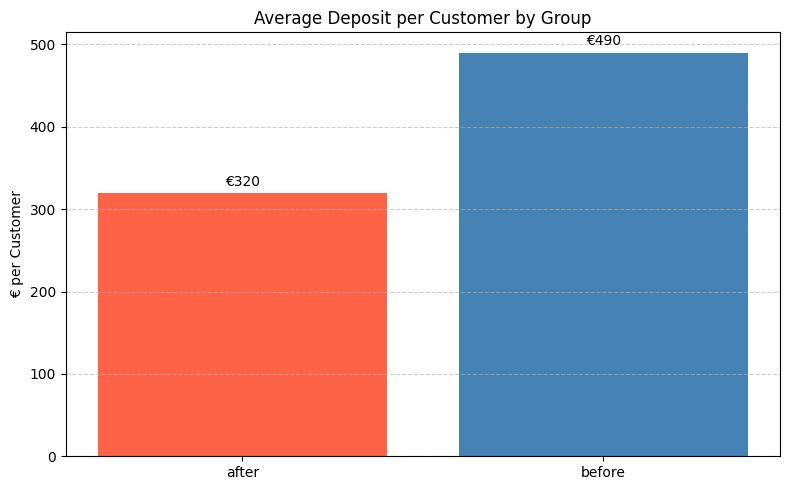

In [16]:
# Exportar CSVs
pivot.to_csv(base_path + 'registration_funnel_by_group.csv', index=True)
quality_df.to_csv(base_path + 'customer_quality_by_group.csv', index=False)

# Exportar XLSX com formatação
with pd.ExcelWriter(base_path + 'registration_funnel_by_group.xlsx', engine='xlsxwriter') as writer:
    pivot.to_excel(writer, sheet_name='Funnel')
    workbook = writer.book
    worksheet = writer.sheets['Funnel']

    percent_format = workbook.add_format({'num_format': '0.00%'})
    int_format = workbook.add_format({'num_format': '0'})

    worksheet.set_column('A:A', 15)
    worksheet.set_column('B:E', 12, int_format)
    worksheet.set_column('F:F', 18, percent_format)

with pd.ExcelWriter(base_path + 'customer_quality_by_group.xlsx', engine='xlsxwriter') as writer:
    quality_df.to_excel(writer, index=False, sheet_name='Quality')
    workbook = writer.book
    worksheet = writer.sheets['Quality']

    percent_format = workbook.add_format({'num_format': '0.00"%"'})
    money_format = workbook.add_format({'num_format': '€#,##0.00'})
    int_format = workbook.add_format({'num_format': '0'})

    worksheet.set_column('A:A', 12)
    worksheet.set_column('B:C', 18, int_format)
    worksheet.set_column('D:D', 22, money_format)
    worksheet.set_column('E:E', 22, percent_format)
    worksheet.set_column('F:F', 28, money_format)

# Gráfico
plt.figure(figsize=(8, 5))
bars = plt.bar(quality_df['Group'], quality_df['Avg_Deposit_per_Customer (€)'], color=['tomato', 'steelblue'])
plt.title('Average Deposit per Customer by Group')
plt.ylabel('€ per Customer')
plt.grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, f"€{yval:,.0f}", ha='center', va='bottom')
plt.tight_layout()
plt.savefig(base_path + 'avg_deposit_per_customer.png')
plt.show()


In [17]:
# Agrupar por cliente e contar quantos dias diferentes ele depositou
dias_ativos = deposits_email.groupby('Customer_ID')['Transaction_Date'].nunique().reset_index(name='dias_ativos')

# Juntar com o grupo (before/after)
dias_ativos = dias_ativos.merge(email_customers[['Customer_ID', 'Group']], on='Customer_ID', how='left')

# Ver distribuição
retencao = dias_ativos.groupby(['Group', 'dias_ativos']).size().unstack(fill_value=0)

retencao


dias_ativos,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,31
Group,,,,,,,,,,,,,,,,,,,,,
after,148115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
before,201786,4081,1429,819,525,388,321,256,166,131,...,19,14,6,5,5,3,5,1,3,1
